In [1]:
import os, torch, random, time

# IMPORTANT: Fix for PyTorch/IPython compatibility issue
# This must run BEFORE importing torch to avoid decorator conflicts
# This fixes the "disable() got an unexpected keyword argument 'wrapping'" error

# Method 1: Try to disable dynamo via environment variable (needs to be set before import)
os.environ.setdefault('TORCH_COMPILE_DISABLE', '1')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Method 2: Patch torch._dynamo.disable decorator after import
try:
    import torch._dynamo
    # Patch the disable function to ignore the 'wrapping' parameter
    if hasattr(torch._dynamo, 'disable'):
        def patched_disable(fn=None, *args, **kwargs):
            # Remove problematic 'wrapping' parameter if present
            if 'wrapping' in kwargs:
                kwargs.pop('wrapping')
            if fn is None:
                # Decorator usage: @disable
                return lambda f: f
            # Function usage: disable(fn) or disable(fn, **kwargs)
            # Simply return the function unwrapped to avoid recursion
            # The original disable was causing issues, so we bypass it entirely
            return fn
        torch._dynamo.disable = patched_disable
except Exception as e:
    print(f"Warning: Could not patch torch._dynamo: {e}")
    pass  # If patching fails, continue anyway

from torchtext import data
import numpy as np

os.environ['GENSIM_DATA_DIR'] = os.path.join(os.getcwd(), 'gensim-data')

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from utils import *

In [2]:
SEED = 42
train_data, validation_data, test_data, LABEL, TEXT, pretrained_embed = data_prep(SEED)

[*] Prepping Data...
[+] Test set formed!
[+] Train and Validation sets formed!
[+] Data prepped successfully!
[*] Retrieving pretrained word embeddings...
[*] Loading fasttext model...
[+] Model loaded!
[*] Forming embedding matrix...
[+] Embedding matrix formed!
[+] Embeddings retrieved successfully!

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Build vocabulary for labels
LABEL.build_vocab(train_data)
num_classes = len(LABEL.vocab)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {LABEL.vocab.itos}")

# Get pretrained embeddings from Part 1 (frozen embeddings)
pretrained_embeddings = pretrained_embed.weight.data

# Get embedding dimension and vocab size from the fasttext embedding layer
embedding_dim = pretrained_embed.weight.shape[1]
embedding_vocab_size = pretrained_embed.weight.shape[0]  # Vocab size from saved embedding


Number of classes: 6
Classes: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [4]:
# ============================================================================
# Part 3.1: biLSTM and biGRU Models
# ============================================================================

print("\n" + "="*80)
print("PART 3.1: biLSTM AND biGRU MODELS")
print("="*80)

# biLSTM Model Class
class BiLSTMClassifier(nn.Module):
    """
    Bidirectional LSTM for topic classification with multiple aggregation strategies.
    Uses pretrained embeddings (learnable/updated during training) with OOV mitigation.
    Incorporates recurrent computations in both directions and supports multiple layers.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5, padding_idx=0, pretrained_embeddings=None,
                 aggregation='last'):
        super(BiLSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = True
        self.aggregation = aggregation  # 'last', 'mean', 'max'
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths
        text_lengths_flat = text_lengths.flatten().cpu().long()
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, expected {batch_size}"
            )
        
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        text_lengths_clamped_device = text_lengths_clamped.to(text.device)
        
        # Pack the padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through LSTM
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden: [n_layers * num_directions, batch_size, hidden_dim]
        # packed_output contains all time-step outputs
        
        # Unpack outputs
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )  # [batch_size, seq_len, hidden_dim * 2]
        
        # Aggregation
        if self.aggregation == 'last':
            # Use the last hidden states from both directions
            forward_hidden = hidden[-2]
            backward_hidden = hidden[-1]
            sentence_repr = torch.cat((forward_hidden, backward_hidden), dim=1)
            
        elif self.aggregation == 'mean':
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
            masked_output = output * mask
            sum_output = masked_output.sum(dim=1)
            sentence_repr = sum_output / text_lengths_clamped_device.unsqueeze(1).float()
            
        elif self.aggregation == 'max':
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()
            
            masked_output = output * mask + (1 - mask) * float('-inf')
            sentence_repr, _ = torch.max(masked_output, dim=1)
                        
        else:
            raise ValueError(f"Invalid aggregation method: {self.aggregation}")
        
        # Apply dropout and classification layer
        sentence_repr = self.dropout(sentence_repr)
        output = self.fc(sentence_repr)
        
        return output



# biGRU Model Class
class BiGRUClassifier(nn.Module):
    """
    Bidirectional GRU for topic classification with multiple aggregation strategies.
    Uses pretrained embeddings (learnable/updated during training) with OOV mitigation.
    Supports 'last', 'mean', 'max', and 'attention' aggregation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5, padding_idx=0, pretrained_embeddings=None,
                 aggregation='last'):
        super(BiGRUClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = True
        self.aggregation = aggregation  # 'last', 'mean', 'max'
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True
        
        # Bidirectional GRU layer
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer (since it's bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Validate text_lengths
        text_lengths_flat = text_lengths.flatten().cpu().long()
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, expected {batch_size}"
            )
        
        # Clamp to avoid zero-length issues
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        text_lengths_clamped_device = text_lengths_clamped.to(text.device)
        
        # Pack sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Forward pass through GRU
        packed_output, hidden = self.gru(packed_embedded)
        # hidden: [n_layers * 2, batch_size, hidden_dim]
        
        # Unpack the output
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )  # [batch_size, seq_len, hidden_dim * 2]
        
        # Aggregation strategies
        if self.aggregation == 'last':
            forward_hidden = hidden[-2]
            backward_hidden = hidden[-1]
            sentence_repr = torch.cat((forward_hidden, backward_hidden), dim=1)
            
        elif self.aggregation == 'mean':
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            masked_output = output * mask
            sum_output = masked_output.sum(dim=1)
            sentence_repr = sum_output / text_lengths_clamped_device.unsqueeze(1).float()
            
        elif self.aggregation == 'max':
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()
            masked_output = output * mask + (1 - mask) * float('-inf')
            sentence_repr, _ = torch.max(masked_output, dim=1)
            
        else:
            raise ValueError(f"Invalid aggregation method: {self.aggregation}")
        
        # Apply dropout and output projection
        sentence_repr = self.dropout(sentence_repr)
        output = self.fc(sentence_repr)
        
        return output


print(">>> Model classes created: BiLSTMClassifier and BiGRUClassifier")



PART 3.1: biLSTM AND biGRU MODELS
>>> Model classes created: BiLSTMClassifier and BiGRUClassifier


In [ ]:
# ============================================================================
# Train biLSTM Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING biLSTM MODEL")
print("="*80)

# Use best hyperparameters from Part 2 (or reasonable defaults)
# Based on Part 2 results, using: LR=0.0001, Batch=32, Hidden=512, but we'll use Hidden=256 for biLSTM
# since bidirectional doubles the effective hidden size
BILSTM_HYPERPARAM = hyperparam_prep()

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Create iterators
train_iter_bilstm = data.BucketIterator(
    train_data,
    batch_size=BILSTM_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_bilstm = data.BucketIterator(
    validation_data,
    batch_size=BILSTM_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_bilstm = data.BucketIterator(
    test_data,
    batch_size=BILSTM_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create biLSTM model
bilstm_model = BiLSTMClassifier(
    vocab_size=embedding_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=BILSTM_HYPERPARAM['HIDDEN_DIM'],
    output_dim=num_classes,
    n_layers=BILSTM_HYPERPARAM['N_LAYERS'],
    dropout=BILSTM_HYPERPARAM['DROPOUT'],
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    aggregation=BILSTM_HYPERPARAM['AGGREGATOR'],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
bilstm_optimizer = optim.RMSprop(bilstm_model.parameters(), lr=BILSTM_HYPERPARAM['LEARNING_RATE'],
                                    weight_decay=BILSTM_HYPERPARAM['L2_LAMBDA'])

print(f"\n>>> biLSTM Model Configuration:")
print(f"    Hidden Dim: {BILSTM_HYPERPARAM['HIDDEN_DIM']} (effective: {BILSTM_HYPERPARAM['HIDDEN_DIM'] * 2} due to bidirectional)")
print(f"    Layers: {BILSTM_HYPERPARAM['N_LAYERS']}")
print(f"    Dropout: {BILSTM_HYPERPARAM['DROPOUT']}")
print(f"    Learning Rate: {BILSTM_HYPERPARAM['LEARNING_RATE']}")
print(f"    Batch Size: {BILSTM_HYPERPARAM['BATCH_SIZE']}")
print(f"    Max Epochs: {BILSTM_HYPERPARAM['N_EPOCHS']}, Patience: {BILSTM_HYPERPARAM['PATIENCE']}")

# Train biLSTM
bilstm_model, bilstm_history = train_model_with_history(
    bilstm_model, train_iter_bilstm, val_iter_bilstm, bilstm_optimizer, criterion,
    BILSTM_HYPERPARAM['N_EPOCHS'], device, num_classes, BILSTM_HYPERPARAM['L1_LAMBDA'], patience=BILSTM_HYPERPARAM['PATIENCE'], model_name="biLSTM"
)

# Save best model
torch.save(bilstm_model.state_dict(), 'weights/bilstm_best.pt')
print(f"\n>>> biLSTM model saved to 'weights/bilstm_best.pt'")



TRAINING biLSTM MODEL

>>> biLSTM Model Configuration:
    Hidden Dim: 256 (effective: 512 due to bidirectional)
    Layers: 2
    Dropout: 0.5
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10

>>> Training biLSTM
    Parameters: 5,155,522
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 6s
	Train Loss: 1.7337 | Train Acc: 27.97%
	Val Loss: 1.4120 | Val Acc: 43.03% | Val F1: 0.3341 | Val AUC: 0.7670
Epoch: 02/100 | Time: 0m 6s
	Train Loss: 1.3390 | Train Acc: 50.46%
	Val Loss: 1.0930 | Val Acc: 57.34% | Val F1: 0.5632 | Val AUC: 0.8548
Epoch: 03/100 | Time: 0m 5s
	Train Loss: 1.1207 | Train Acc: 60.34%
	Val Loss: 0.9710 | Val Acc: 61.38% | Val F1: 0.6000 | Val AUC: 0.8846
Epoch: 04/100 | Time: 0m 5s
	Train Loss: 0.9535 | Train Acc: 68.48%
	Val Loss: 0.8808 | Val Acc: 67.25% | Val F1: 0.6692 | Val AUC: 0.9037
Epoch: 05/100 | Time: 0m 6s
	Train Loss: 0.8032 | Train Acc: 75.17%
	Val Loss: 0.8856 | Val Acc: 67.98% | Val F1: 0.6832 | Val AUC: 0.9081


In [ ]:
# ============================================================================
# Train biGRU Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING biGRU MODEL")
print("="*80)

# Use same hyperparameters as biLSTM for fair comparison
BIGRU_HYPERPARAM = hyperparam_prep()

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Create iterators
train_iter_bigru = data.BucketIterator(
    train_data,
    batch_size=BIGRU_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_bigru = data.BucketIterator(
    validation_data,
    batch_size=BIGRU_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_bigru = data.BucketIterator(
    test_data,
    batch_size=BIGRU_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create biGRU model
bigru_model = BiGRUClassifier(
    vocab_size=embedding_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=BIGRU_HYPERPARAM['HIDDEN_DIM'],
    output_dim=num_classes,
    n_layers=BIGRU_HYPERPARAM['N_LAYERS'],
    dropout=BIGRU_HYPERPARAM['DROPOUT'],
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    aggregation=BIGRU_HYPERPARAM['AGGREGATOR'],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
bigru_optimizer = optim.RMSprop(bigru_model.parameters(), lr=BIGRU_HYPERPARAM['LEARNING_RATE'], 
                                    weight_decay=BIGRU_HYPERPARAM['L2_LAMBDA'])

print(f"\n>>> biGRU Model Configuration:")
print(f"    Hidden Dim: {BIGRU_HYPERPARAM['HIDDEN_DIM']} (effective: {BIGRU_HYPERPARAM['HIDDEN_DIM'] * 2} due to bidirectional)")
print(f"    Layers: {BIGRU_HYPERPARAM['N_LAYERS']}")
print(f"    Dropout: {BIGRU_HYPERPARAM['DROPOUT']}")
print(f"    Learning Rate: {BIGRU_HYPERPARAM['LEARNING_RATE']}")
print(f"    Batch Size: {BIGRU_HYPERPARAM['BATCH_SIZE']}")
print(f"    Max Epochs: {BIGRU_HYPERPARAM['N_EPOCHS']}, Patience: {BIGRU_HYPERPARAM['PATIENCE']}")

# Train biGRU
bigru_model, bigru_history = train_model_with_history(
    bigru_model, train_iter_bigru, val_iter_bigru, bigru_optimizer, criterion,
    BIGRU_HYPERPARAM['N_EPOCHS'], device, num_classes, BIGRU_HYPERPARAM['L1_LAMBDA'], patience=BIGRU_HYPERPARAM['PATIENCE'], model_name="biGRU"
)

# Save best model
torch.save(bigru_model.state_dict(), 'weights/bigru_best.pt')
print(f"\n>>> biGRU model saved to 'weights/bigru_best.pt'")



TRAINING biGRU MODEL

>>> biGRU Model Configuration:
    Hidden Dim: 256 (effective: 512 due to bidirectional)
    Layers: 2
    Dropout: 0.5
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10

>>> Training biGRU
    Parameters: 4,475,586
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 4s
	Train Loss: 1.6761 | Train Acc: 31.71%
	Val Loss: 1.2808 | Val Acc: 44.59% | Val F1: 0.3609 | Val AUC: 0.8129
Epoch: 02/100 | Time: 0m 4s
	Train Loss: 1.2341 | Train Acc: 55.59%
	Val Loss: 0.9914 | Val Acc: 62.75% | Val F1: 0.6159 | Val AUC: 0.8824
Epoch: 03/100 | Time: 0m 4s
	Train Loss: 0.9388 | Train Acc: 68.39%
	Val Loss: 0.8778 | Val Acc: 70.09% | Val F1: 0.6916 | Val AUC: 0.9124
Epoch: 04/100 | Time: 0m 5s
	Train Loss: 0.7478 | Train Acc: 76.75%
	Val Loss: 0.7489 | Val Acc: 73.30% | Val F1: 0.7302 | Val AUC: 0.9320
Epoch: 05/100 | Time: 0m 4s
	Train Loss: 0.5684 | Train Acc: 84.69%
	Val Loss: 0.6722 | Val Acc: 75.87% | Val F1: 0.7589 | Val AUC: 0.9476
Epo


PLOTTING TRAINING CURVES
    Saved training curves to 'part3_1_bilstm_bigru_training_curves.png'


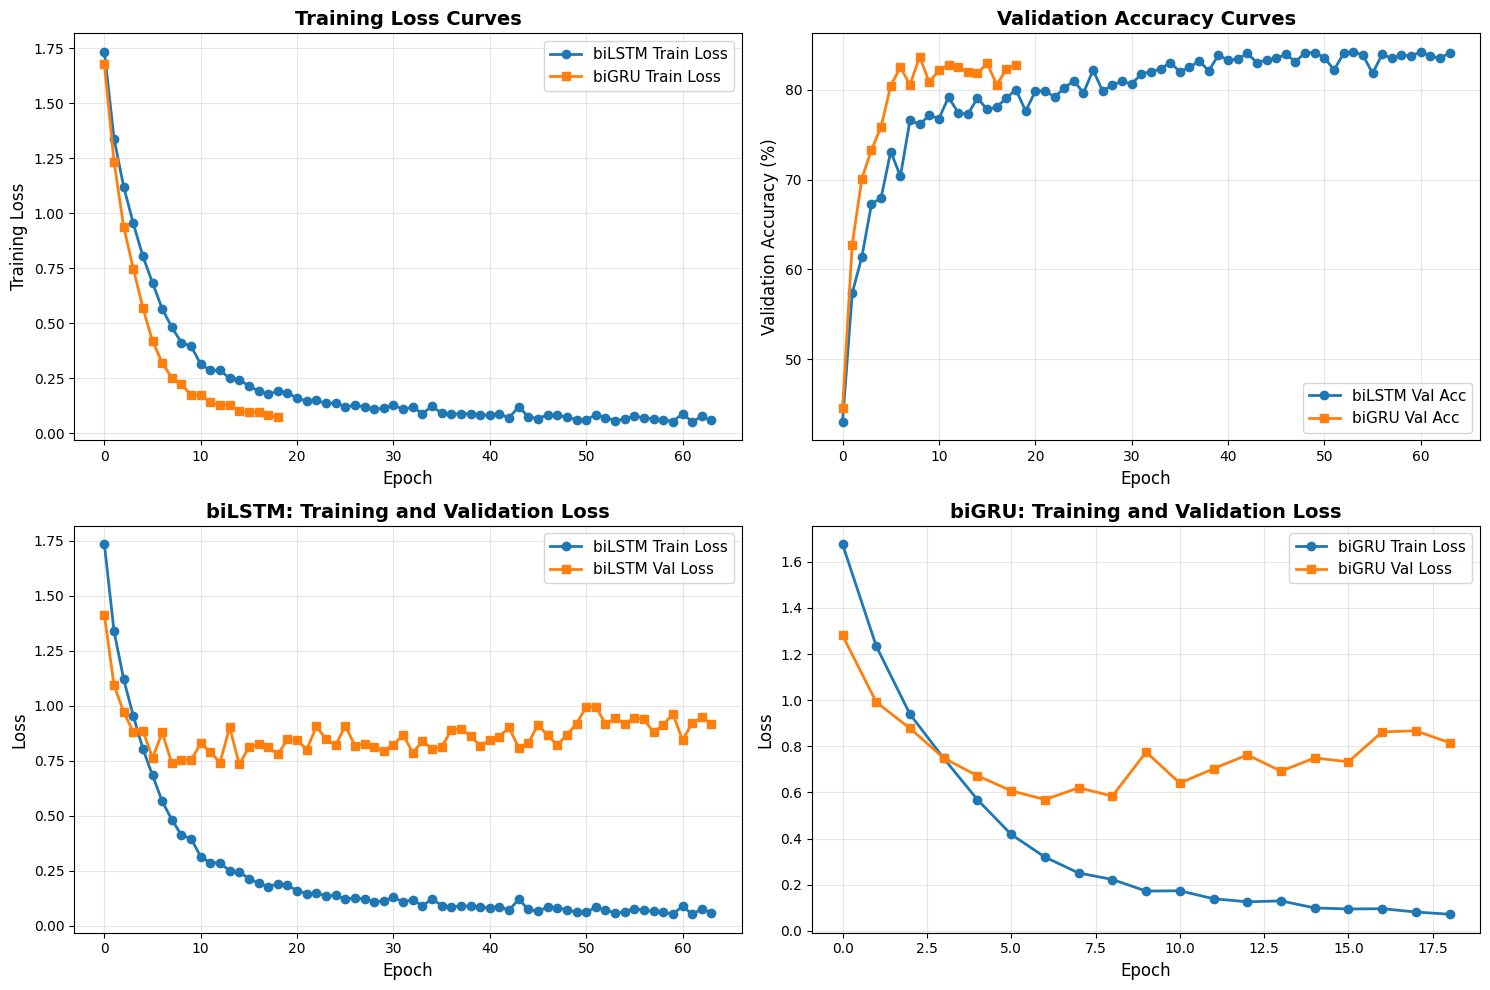

    Saved Part 3.1 curves to 'part3_1_training_curves.png'


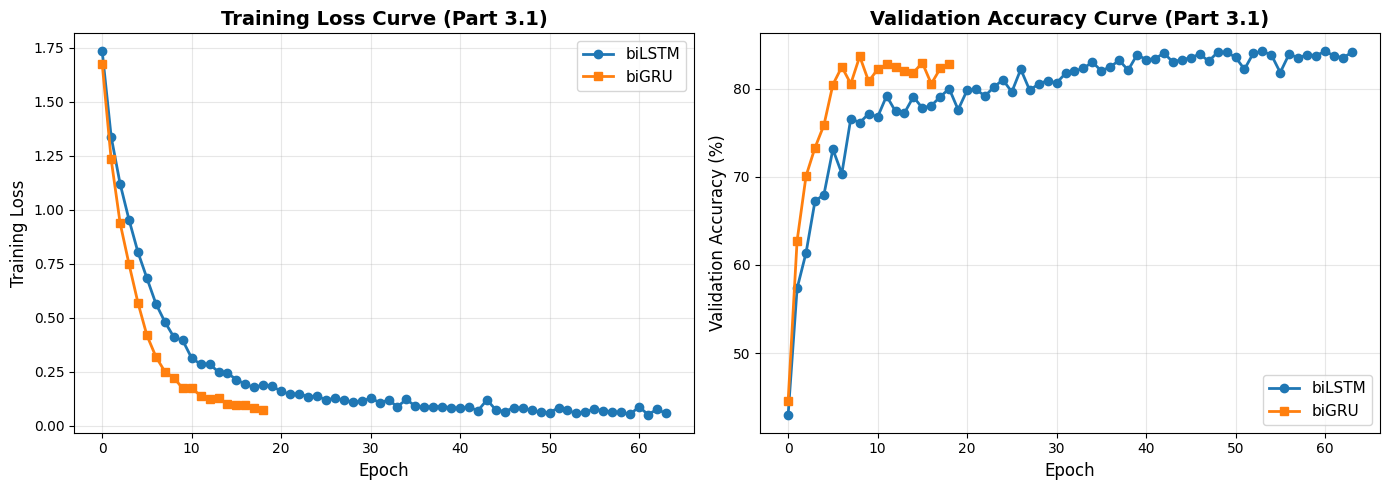

In [9]:
# ============================================================================
# Plot Training Curves for biLSTM and biGRU
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES")
print("="*80)

import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss Curves
axes[0, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Curves', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves
axes[0, 1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
axes[0, 1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Accuracy Curves', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: biLSTM Training and Validation Loss
axes[1, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[1, 0].plot(bilstm_history['val_losses'], label='biLSTM Val Loss', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('biLSTM: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: biGRU Training and Validation Loss
axes[1, 1].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='o', linewidth=2)
axes[1, 1].plot(bigru_history['val_losses'], label='biGRU Val Loss', marker='s', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Loss', fontsize=12)
axes[1, 1].set_title('biGRU: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_1_bilstm_bigru_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_1_bilstm_bigru_training_curves.png'")
plt.show()

# Also create separate plots for Part 3.1 requirement (training loss and validation accuracy)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss Curve
ax1.plot(bilstm_history['train_losses'], label='biLSTM', marker='o', linewidth=2)
ax1.plot(bigru_history['train_losses'], label='biGRU', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Curve (Part 3.1)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM', marker='o', linewidth=2)
ax2.plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (Part 3.1)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_1_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.1 curves to 'part3_1_training_curves.png'")
plt.show()


In [10]:
# ============================================================================
# Evaluate biLSTM and biGRU on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - biLSTM AND biGRU")
print("="*80)

# Evaluate biLSTM
print("\n>>> Evaluating biLSTM on test set...")
bilstm_test_loss, bilstm_test_acc, bilstm_test_f1, bilstm_test_auc = evaluate_model(
    bilstm_model, test_iter_bilstm, criterion, device, "biLSTM", num_classes
)

print(f"\n>>> biLSTM Test Set Results:")
print(f"    Test Loss: {bilstm_test_loss:.4f}")
print(f"    Test Accuracy: {bilstm_test_acc*100:.2f}%")
print(f"    Test F1 Score: {bilstm_test_f1:.4f}")
print(f"    Test AUC-ROC: {bilstm_test_auc:.4f}")

# Evaluate biGRU
print("\n>>> Evaluating biGRU on test set...")
bigru_test_loss, bigru_test_acc, bigru_test_f1, bigru_test_auc = evaluate_model(
    bigru_model, test_iter_bigru, criterion, device, "biGRU", num_classes
)

print(f"\n>>> biGRU Test Set Results:")
print(f"    Test Loss: {bigru_test_loss:.4f}")
print(f"    Test Accuracy: {bigru_test_acc*100:.2f}%")
print(f"    Test F1 Score: {bigru_test_f1:.4f}")
print(f"    Test AUC-ROC: {bigru_test_auc:.4f}")

# Summary comparison
print("\n" + "="*80)
print("PART 3.1 SUMMARY - biLSTM vs biGRU")
print("="*80)
print(f"{'Model':<10} {'Test Accuracy':<15} {'Test F1':<12} {'Val Acc (Best)':<15}")
print("-" * 60)
print(f"{'biLSTM':<10} {bilstm_test_acc*100:<15.2f}% {bilstm_test_f1:<12.4f} {bilstm_history['best_val_acc']*100:<15.2f}%")
print(f"{'biGRU':<10} {bigru_test_acc*100:<15.2f}% {bigru_test_f1:<12.4f} {bigru_history['best_val_acc']*100:<15.2f}%")
print("="*80)

print("\n>>> Part 3.1 Complete!")
print("    - biLSTM and biGRU models trained with bidirectional and multiple layers")
print("    - Training curves plotted and saved")
print("    - Test set accuracies reported above")



TEST SET EVALUATION - biLSTM AND biGRU

>>> Evaluating biLSTM on test set...

>>> biLSTM Test Set Results:
    Test Loss: 0.7982
    Test Accuracy: 87.00%
    Test F1 Score: 0.8698
    Test AUC-ROC: 0.9523

>>> Evaluating biGRU on test set...

>>> biGRU Test Set Results:
    Test Loss: 0.5765
    Test Accuracy: 87.40%
    Test F1 Score: 0.8734
    Test AUC-ROC: 0.9698

PART 3.1 SUMMARY - biLSTM vs biGRU
Model      Test Accuracy   Test F1      Val Acc (Best) 
------------------------------------------------------------
biLSTM     87.00          % 0.8698       84.22          %
biGRU      87.40          % 0.8734       83.67          %

>>> Part 3.1 Complete!
    - biLSTM and biGRU models trained with bidirectional and multiple layers
    - Training curves plotted and saved
    - Test set accuracies reported above
